### Make paths to directories

In [26]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

Irish_data_dir = os.path.join(parent_dir, 'Data/Irish_dataset/preprocessed')
results_dir = os.path.join(current_dir, 'resultsIreland')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator


### Imports

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [29]:
def season_from_date(date):
    month = date.month
    if 3 <= month <= 5:
        return 2
    elif 6 <= month <= 8:
        return 3
    elif 9 <= month <= 11:
        return 1
    return 4

In [30]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def london_dataset(london_data_dir=Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    #return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def london_dataset_with_buffer(buffer_attributes, startdate = pd.to_datetime('2010-05-01'), london_data_dir = Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl", weekdays_only = True):
    return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes) #combined_attributes_filtered.pkl
    buffer_attributes_path = os.path.join(london_data_dir, buffer_attributes) #daily_data_df_filtered.pkl
    timeseries_path = os.path.join(london_data_dir, timeseries) #buffer_attributes_march_df.pkl
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    buffer_attributes = pd.read_pickle(buffer_attributes_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")

    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    # Assuming timeseries and attributes are your DataFrames
    # Extract the date part from the MultiIndex of timeseries
    dates = timeseries.index.get_level_values(1)

    # Replace '1' with the correct level if different
    dates = pd.to_datetime(dates)
    # Calculate the difference in days from January 1st, 2010
    start_date = startdate
    days_diff = (dates - start_date).days

    # Add this information to the attributes DataFrame
    # Assuming the order and length of rows in both DataFrames are the same
    merged_attributes['TimeFromBuffer'] = days_diff
    season = season_from_date(start_date)
    merged_attributes['sameseason'] = merged_attributes['season'] == season
    to_drop = get_meterids_with_NaNs(merged_attributes)
    merged_attributes = merged_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(merged_attributes), dtype= 'int'), 5)

    return merged_attributes, timeseries, folds

In [31]:
def generate_dataset_with_2_buffer(buffer_attributes1, buffer_attributes2,start,end, london_data_dir = Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):    
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes) 
    buffer_attributes1_path = os.path.join(london_data_dir, buffer_attributes1)
    buffer_attributes2_path = os.path.join(london_data_dir, buffer_attributes2)
    timeseries_path = os.path.join(london_data_dir, timeseries) 
    
    timeseries = pd.read_pickle(timeseries_path)


    # Read data into DataFrames
    attributes = pd.read_pickle(attributes_path)
    buffer_attributes1 = pd.read_pickle(buffer_attributes1_path)
    buffer_attributes2 = pd.read_pickle(buffer_attributes2_path)
    
    # Add a new column to the original attributes DataFrame
    attributes['row_index'] = range(len(attributes))
    
    # Filter attributes DataFrame
    attributes1 = attributes[attributes['dayOfYear'].between(start,end)]
    attributes2 = attributes[~attributes['dayOfYear'].between(start,end)]
    
    # Merge DataFrames
    merged_attributes1 = attributes1.merge(buffer_attributes1, on=['meterID'], how="left")
    merged_attributes2 = attributes2.merge(buffer_attributes2, on=['meterID'], how="left")
    
    # Combine merged DataFrames
    combined_attributes = pd.concat([merged_attributes1, merged_attributes2])
    
    # Sort DataFrame based on the new column 'row_index'
    combined_attributes.sort_values(by='row_index', inplace=True)
    
    # Drop the 'row_index' column
    combined_attributes.drop(columns='row_index', inplace=True)
    combined_attributes = combined_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])
    to_drop = get_meterids_with_NaNs(combined_attributes)
    combined_attributes = combined_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    
    return combined_attributes, timeseries, folds, True, start, end



In [32]:
def generate_dataset_with_2_baseline(start,end,london_data_dir=Irish_data_dir, attributes = "combined_attributes_filtered.pkl", timeseries = "daily_data_df_filtered.pkl"):
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)

    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    
    return attributes, timeseries, folds, True, start, end

In [33]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

In [34]:
def get_meterids_with_NaNs(df):
    meterids_with_nans = set()
    for meterid, row in df.iterrows():
        if row.isna().any():
            meterids_with_nans.add(meterid)
    return meterids_with_nans



# Thesis experiment

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/ThesisResults2buffers'), nb_of_samples = 250)

    .add_methods(
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
     
    )
    .add_datasets(
        Ireland_Jan_Jul_baseline = generate_dataset_with_2_baseline(91,273),
        Ireland_Feb_Aug_baseline = generate_dataset_with_2_baseline(122,304),
        Ireland_Mar_Sep_baseline = generate_dataset_with_2_baseline(153, 335),
        Ireland_Apr_Okt_baseline = generate_dataset_with_2_baseline(183, 365),
        Ireland_May_Nov_baseline = generate_dataset_with_2_baseline(30,212),
        Ireland_Jun_Dec_baseline = generate_dataset_with_2_baseline(61, 243),
        )
)

energy_scores, timing_df = experiment.execute()


Methods: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, method=PCT_D8_M250]


In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


experiment = (
    ComparisonExperiment(result_path = Path('resultsIreland/ThesisResults2buffers'), nb_of_samples = 250)

    .add_methods(
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 250)),
     
    )
    .add_datasets(
        Ireland_Jan_Jul = generate_dataset_with_2_buffer('buffer_attributes_month_7_all_catch22_df.pkl', 'buffer_attributes_month_1_all_catch22_df.pkl',91,273),
        Ireland_Feb_Aug = generate_dataset_with_2_buffer('buffer_attributes_month_8_all_catch22_df.pkl', 'buffer_attributes_month_2_all_catch22_df.pkl',122,304),
        Ireland_Mar_Sep = generate_dataset_with_2_buffer('buffer_attributes_month_9_all_catch22_df.pkl', 'buffer_attributes_month_3_all_catch22_df.pkl', 153, 335),
        Ireland_Apr_Okt = generate_dataset_with_2_buffer('buffer_attributes_month_10_all_catch22_df.pkl', 'buffer_attributes_month_4_all_catch22_df.pkl', 183, 365),
        Ireland_May_Nov = generate_dataset_with_2_buffer('buffer_attributes_month_5_all_catch22_df.pkl', 'buffer_attributes_month_11_all_catch22_df.pkl',30,212),
        Ireland_Jun_Dec = generate_dataset_with_2_buffer('buffer_attributes_month_6_all_catch22_df.pkl', 'buffer_attributes_month_12_all_catch22_df.pkl',61, 243),
)
)

energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)

Methods: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s, method=PCT_D8_M250]


# Experiments Interface

In [39]:
# set the correct index to the energy scores
ldf = london_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

Index([2010-01-01, 2010-01-02, 2010-01-03, 2010-01-04, 2010-01-05, 2010-01-06,
       2010-01-07, 2010-01-08, 2010-01-09, 2010-01-10,
       ...
       2010-12-22, 2010-12-23, 2010-12-24, 2010-12-25, 2010-12-26, 2010-12-27,
       2010-12-28, 2010-12-29, 2010-12-30, 2010-12-31],
      dtype='object', name='date', length=1090180)

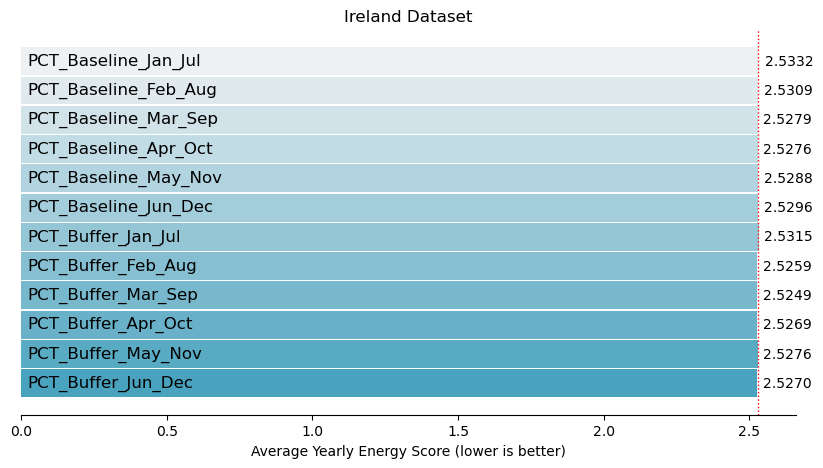

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Ireland Dataset')
plt.savefig('pictures/energy_score_comparison_ireland_2buffers.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()

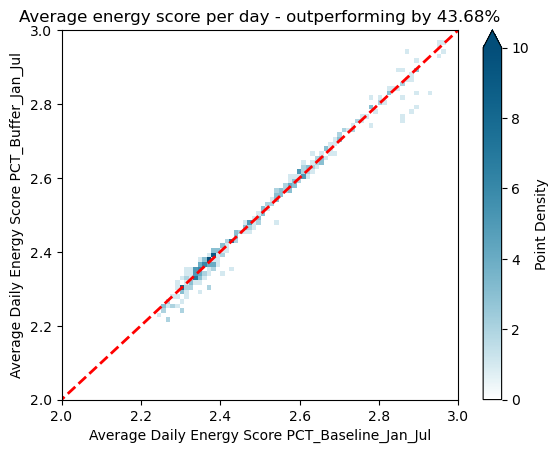

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 0]
technique_B = df_avg.iloc[:, 6]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline_Jan_Jul')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Jan_Jul')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(2, 3)
plt.ylim(2, 3)
# Show the plot
plt.savefig('pictures/Irelanddailycomparison2buffers.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [20]:
for i in range(6):
    technique_A = df_avg.iloc[:, i]
    technique_B = df_avg.iloc[:, i+6]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  43.68131868131868
lower in A:  52.197802197802204
lower in A:  53.2967032967033
lower in A:  38.18681318681318
lower in A:  48.35164835164835
lower in A:  44.78021978021978


In [41]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Rename the index for clarity
monthly_means.index = techniques#['PCT January', 'PCT February', 'PCT March', 'PCT April', 'PCT May', 'PCT June', 'PCT July', 'PCT August', 'PCT September', 'PCT October', 'PCT November', 'PCT December']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,2.810365,2.694175,2.542166,2.456872,2.406294,2.338892,2.370442,2.397515,2.419659,2.451803,2.572695,2.942185
PCT_Baseline_Feb_Aug,2.810678,2.694019,2.543055,2.449285,2.404538,2.333157,2.366439,2.392903,2.415082,2.453361,2.570445,2.942712
PCT_Baseline_Mar_Sep,2.810463,2.695271,2.539483,2.443512,2.396393,2.331235,2.362521,2.390162,2.411024,2.449059,2.568599,2.941632
PCT_Baseline_Apr_Oct,2.811395,2.690342,2.548952,2.447434,2.396859,2.329385,2.361844,2.388303,2.409418,2.446476,2.568845,2.937075
PCT_Baseline_May_Nov,2.807255,2.694680,2.547253,2.449576,2.397760,2.329019,2.363056,2.389932,2.410254,2.449553,2.572266,2.939692
PCT_Baseline_Jun_Dec,2.808450,2.689679,2.545186,2.450867,2.399573,2.331590,2.364263,2.390575,2.413169,2.450740,2.573948,2.941614
PCT_Buffer_Jan_Jul,2.769238,2.688213,2.548143,2.469905,2.412884,2.328215,2.338586,2.388194,2.428227,2.467447,2.579850,2.964326
PCT_Buffer_Feb_Aug,2.783902,2.641294,2.527861,2.469998,2.413871,2.330950,2.352715,2.360731,2.418327,2.471265,2.572668,2.968231
PCT_Buffer_Mar_Sep,2.803589,2.672944,2.512102,2.446415,2.405466,2.333804,2.361592,2.382703,2.387695,2.453531,2.578534,2.962428
PCT_Buffer_Apr_Oct,2.822492,2.692226,2.551693,2.429639,2.397439,2.336840,2.371156,2.391942,2.396325,2.423280,2.570857,2.944216


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for i, v in enumerate(x):
        style = color_gradient(v, min(x), max(x), base_val)
        if i >= 6 and v < x[i - 6]:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_2Baselines Comparison</b>"))


# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,2.81037,2.69417,2.54217,2.45687,2.40629,2.33889,2.37044,2.39751,2.41966,2.45180,2.57269,2.94219
PCT_Baseline_Feb_Aug,2.81068,2.69402,2.54305,2.44928,2.40454,2.33316,2.36644,2.39290,2.41508,2.45336,2.57045,2.94271
PCT_Baseline_Mar_Sep,2.81046,2.69527,2.53948,2.44351,2.39639,2.33124,2.36252,2.39016,2.41102,2.44906,2.56860,2.94163
PCT_Baseline_Apr_Oct,2.81139,2.69034,2.54895,2.44743,2.39686,2.32939,2.36184,2.38830,2.40942,2.44648,2.56885,2.93708
PCT_Baseline_May_Nov,2.80725,2.69468,2.54725,2.44958,2.39776,2.32902,2.36306,2.38993,2.41025,2.44955,2.57227,2.93969
PCT_Baseline_Jun_Dec,2.80845,2.68968,2.54519,2.45087,2.39957,2.33159,2.36426,2.39058,2.41317,2.45074,2.57395,2.94161
PCT_Buffer_Jan_Jul,2.76924,2.68821,2.54814,2.46990,2.41288,2.32821,2.33859,2.38819,2.42823,2.46745,2.57985,2.96433
PCT_Buffer_Feb_Aug,2.78390,2.64129,2.52786,2.47000,2.41387,2.33095,2.35271,2.36073,2.41833,2.47127,2.57267,2.96823
PCT_Buffer_Mar_Sep,2.80359,2.67294,2.51210,2.44641,2.40547,2.33380,2.36159,2.38270,2.38769,2.45353,2.57853,2.96243
PCT_Buffer_Apr_Oct,2.82249,2.69223,2.55169,2.42964,2.39744,2.33684,2.37116,2.39194,2.39632,2.42328,2.57086,2.94422
